In [1]:
# Error with scientific format in plot axes
ENV["GKS_ENCODING"] = "utf8"

using Plots
using Printf
using Statistics

# Avoid huge svg blobs
gr(fmt="png")
nothing

```julia
using Revise
```

In [2]:
module CliffWalking

import ReinforcementLearningSutton.Commons: actions, finished, restart, state, update
using ReinforcementLearningSutton.Commons: I2, T2, state_set, tuple2index
using ReinforcementLearningSutton.GridWorld: GameGridWorldBase, GameGridWorld, dims

struct Cliff
    state_start::I2
    state_goal::I2
    track::Array{Bool, 2}
    penalty::Int
    
    function Cliff(game0::GameGridWorldBase, pos_start::T2, pos_goal::T2, track::Array{Bool, 2}, penalty::Int)
        new(state(game0, pos_start), state(game0, pos_goal), track, penalty)
    end
end

const GameType = GameGridWorld{GameGridWorldBase{T2, T2}, Cliff}

actions(game::GameType, state::I2) = game.game0.actions
finished(game::GameType) = (state(game) == game.ruleset.state_goal)
restart(game::GameType) = state_set(game, game.ruleset.state_start)

function update(game::GameType, action::I2)::Int
    s0 = state(game)
    
    pos_x = max(1, min(s0.value[1] + action.value[1], dims(game)[1]))
    pos_y = max(1, min(s0.value[2] + action.value[2], dims(game)[2]))
    penalty = ifelse(game.ruleset.track[pos_y, pos_x], game.ruleset.penalty, -1)
    
    if penalty < -1
        restart(game)
    else
        s = state(game, (pos_x, pos_y))
        state_set(game, s)
    end
    penalty
end

end;

In [3]:
using ReinforcementLearningSutton.Commons: LearningSarsa, LearningSarsaExpected, LearningQ, PlayerεGreedy, play_game
using ReinforcementLearningSutton.GridWorld: GameGridWorldBase, GameGridWorld

In [4]:
dims = (12, 4)
pos_start = (1, 4)
pos_goal = (12, 4)

allowed_movements = [( 1,  0), ( 0,  1), (-1,  0), ( 0, -1)]

cliff_track = zeros(Bool, reverse(dims)...)
cliff_track[4, 2:(end-1)] .= true

game0 = GameGridWorldBase(dims, allowed_movements)
cliff = CliffWalking.Cliff(game0, pos_start, pos_goal, cliff_track, -100)
game = GameGridWorld(game0, cliff);

### Single parameter comparison

In [5]:
ε = 0.1
α = 0.5
γ = 1.0

max_nsteps = 1000
ngames = 100000;

#### Sarsa

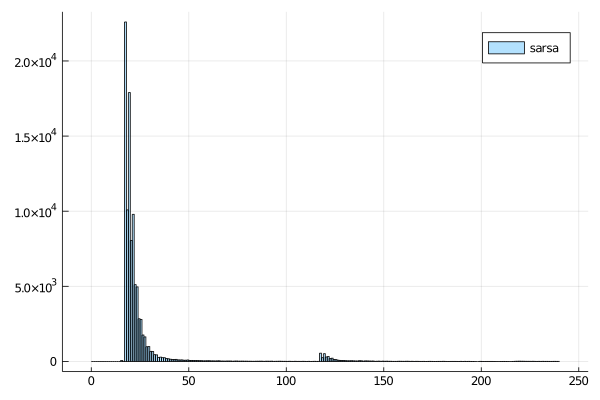

In [6]:
player = PlayerεGreedy(game, ε)
learning = LearningSarsa(player, α, γ)

results_sarsa = -[play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]

histogram(results_sarsa, bins=0:1:240, fillalpha=0.3, label=reshape(["sarsa"], 1, :))

In [7]:
mean(results_sarsa)

26.93465

#### Q-learning

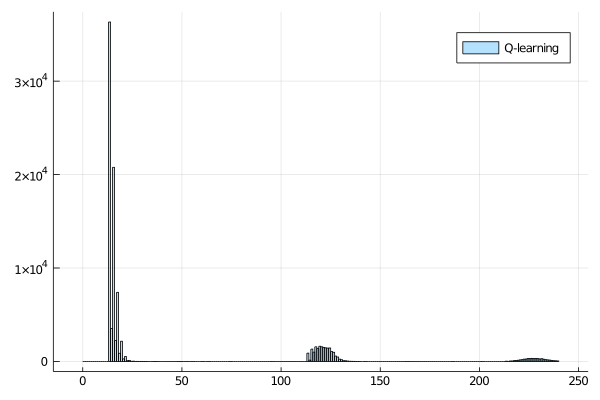

In [8]:
player = PlayerεGreedy(game, ε)
learning = LearningQ(player, α, γ)

results_q = -[play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]

histogram(results_q, bins=0:1:240, fillalpha=0.3, label=reshape(["Q-learning"], 1, :))

In [9]:
mean(results_q)

51.26689

#### Expected Sarsa

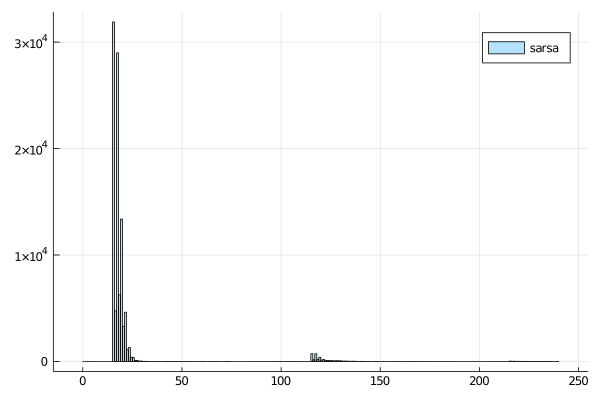

In [10]:
player = PlayerεGreedy(game, ε)
learning = LearningSarsaExpected(player, α, γ)

results_expected_sarsa = -[play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]

histogram(results_expected_sarsa, bins=0:1:240, fillalpha=0.3, label=reshape(["sarsa"], 1, :))

In [11]:
mean(results_expected_sarsa)

20.74465

### Comparison of Sarsa, Q-learning and expected Sarsa

Asymptotic values:

In [12]:
ε = 0.1
αs = 0.1:0.05:1
γ = 1.0;

In [13]:
nrounds = 10
ngames = 10000
max_nsteps = 10000

results_asymptotic = Dict{Tuple{String, Float64}, Array{Float64, 1}}()

for (learning_algo_lbl, learning_algo) in [("Sarsa", LearningSarsa),
                                           ("Q", LearningQ),
                                           ("Expected Sarsa", LearningSarsaExpected)]
    println(learning_algo_lbl)
    for α in αs
        results_asymptotic[(learning_algo_lbl, α)] = Array{Float64, 1}(undef, nrounds)
        for nround in 1:nrounds
            player = PlayerεGreedy(game, ε)
            learning = learning_algo(player, α, γ)
            outcomes = [play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]
            results_asymptotic[(learning_algo_lbl, α)][nround] = mean(outcomes)
        end
    end
end

Sarsa
Q
Expected Sarsa


In [14]:
nrounds = 5000
ngames = 100
max_nsteps = 10000

results = Dict{Tuple{String, Float64}, Array{Float64, 1}}()

for (learning_algo_lbl, learning_algo) in [("Sarsa", LearningSarsa),
                                           ("Q", LearningQ),
                                           ("Expected Sarsa", LearningSarsaExpected)]
    println(learning_algo_lbl)
    for α in αs
        results[(learning_algo_lbl, α)] = Array{Float64, 1}(undef, nrounds)
        for nround in 1:nrounds
            player = PlayerεGreedy(game, ε)
            learning = learning_algo(player, α, γ)
            outcomes = [play_game(game, player, max_nsteps, learning)[2] for _ in 1:ngames]
            results[(learning_algo_lbl, α)][nround] = mean(outcomes)
        end
    end
end

Sarsa
Q
Expected Sarsa


In [15]:
results_summ = Array{Float64, 2}(undef, length(αs), 6)
for (i, learning_algo_lbl) in enumerate(["Sarsa", "Q", "Expected Sarsa"])
    for (j, α) in enumerate(αs)
        results_summ[j, i] = mean(results[(learning_algo_lbl, α)])
        results_summ[j, i + 3] = mean(results_asymptotic[(learning_algo_lbl, α)])
    end
end

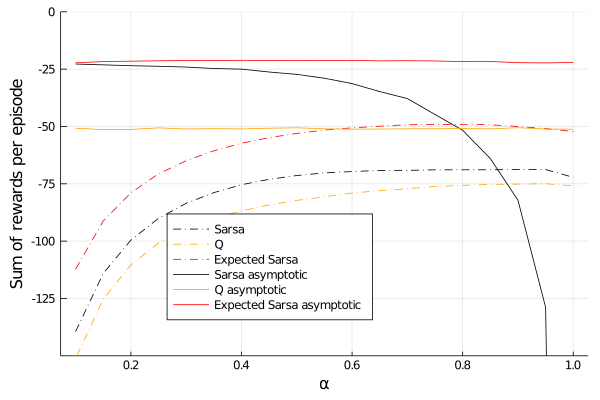

In [16]:
plot(αs, results_summ,
     label=["Sarsa" "Q" "Expected Sarsa" "Sarsa asymptotic" "Q asymptotic" "Expected Sarsa asymptotic"],
     color = [:black :orange :red],
     linestyle = [:dashdot :dashdot :dashdot :solid :solid :solid],
     legend=:bottom,
     xlabel="α",
     ylabel="Sum of rewards per episode")
ylims!((-150, 0))

### Timing and profiling

In [17]:
α = 0.1
learning_algo = LearningSarsa
player = PlayerεGreedy(game, ε)
learning = learning_algo(player, α, γ)
play_game(game, player, max_nsteps, learning)
@time [play_game(game, player, max_nsteps, learning) for _ in 1:1000000]
nothing

  1.161280 seconds (1.04 M allocations: 48.036 MiB, 0.90% gc time)


```julia
using ProfileVega

# The default format SVG creates figures of size 9600x6400
ProfileVega.set_default_size(1200, 800)

function f(game, player, max_nsteps, learning, ngames)
    [play_game(game, player, max_nsteps, learning) for _ in 1:ngames]
end

α = 0.1
learning_algo = LearningSarsa
player = PlayerεGreedy(game, ε)
learning = learning_algo(player, α, γ)
play_game(game, player, max_nsteps, learning)
@profview f(game, player, max_nsteps, learning, 1000000)
```